In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [2]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torchvision.datasets import ImageFolder
import os
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import wandb
import pretrainedmodels

In [3]:
from adamW import AdamW

In [4]:
from lr_finder import LRFinder

/opt/anaconda3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [7]:
!wandb login 671db748b25cac1085359236addb6a92bf70856f

Appending key for api.wandb.ai to your netrc file: /home/azg6els/.netrc
Successfully logged in to Weights & Biases!


In [24]:
wandb.init(project="chandeliers")

W&B Run: https://app.wandb.ai/homedepot/chandeliers/runs/b7s6t8m9
Call `%%wandb` in the cell containing your training loop to display live results.


W&B Run: https://app.wandb.ai/homedepot/chandeliers/runs/b7s6t8m9

In [5]:
path = '../Chandeliers/houzz_style'

In [6]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
 
data_transforms = {
    'train':
        transforms.Compose([
            transforms.Resize((224,224)),
            transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize]),
    'valid':
        transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            normalize])}
 
image_datasets = {
    'train':
        ImageFolder(os.path.join(path,'train'), data_transforms['train']),
    'valid':
        ImageFolder(os.path.join(path,'valid'), data_transforms['valid'])}
 
dataloaders = {
    'train':
        torch.utils.data.DataLoader(
            image_datasets['train'],
            batch_size=8,
            shuffle=True,
            num_workers=4),
    'valid':
        torch.utils.data.DataLoader(
            image_datasets['valid'],
            batch_size=8,
            shuffle=False,
            num_workers=4)}

In [7]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True).to(device)
 
for param in model.parameters():
    param.requires_grad = False

ct = []
for name, child in model.named_children():
    if "maxpool" in ct:
        for params in child.parameters():
           params.requires_grad = True
    ct.append(name)

#optimizer = optim.SGD(list(filter(lambda p: p.requires_grad, model.parameters())), lr=lr, momentum=0.5, weight_decay=1e-4)
optimizer = AdamW(list(filter(lambda p: p.requires_grad, model.parameters())), lr=1e-5, weight_decay=5e-3)


num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 12).to(device)

criterion = nn.CrossEntropyLoss()

print("[Creating Learning rate scheduler...]")

steps = len(dataloaders['train'])
exp_lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, steps)


[Creating Learning rate scheduler...]


In [90]:
#optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)




Learning rate search finished. See the graph with {finder_name}.plot()


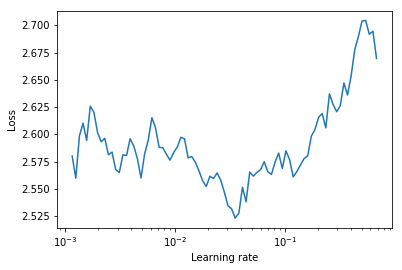

In [17]:
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloaders['train'], end_lr=1, num_iter=100)
lr_finder.plot()

In [12]:
#don't run this
def train_model(model, criterion, optimizer, dataloaders, scheduler=None, num_epochs=3,cycle_mult=1):

    steps = len(dataloaders['train'])
    completed = 0
    
    best_acc = 0.0
    
    dataset_sizes = {'train':len(dataloaders['train'].dataset),'valid':len(dataloaders['valid'].dataset)}
    
    #wandb.watch(model)
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        epoch_loss = 1.0

        for phase in ['train', 'valid']:
            if phase == 'train':
                #if scheduler is not None:
                #    scheduler.step(epoch_loss)
                model.train()
            else:
                model.eval()
 
            running_loss = 0.0
            running_corrects = 0
 
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
 
                outputs = model(inputs)
                loss = criterion(outputs, labels)
 
                if phase == 'train':
                    steps -= 1
                    scheduler.step()
                    #lrval = scheduler.get_lr()
                    #wandb.log({'lr':lrval})
                    #print("lr: ", lrval)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
 
                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
 
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
        
            if phase == 'valid':
                wandb.log({'epoch_loss':epoch_loss,'epoch_acc':epoch_acc})
                
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()
                
            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
        lrval = scheduler.get_lr()[0]
        print('steps: %d lr: %.4f'%(steps,lrval))
        
        if (steps <= 0):
            completed += 1
            steps = len(dataloaders['train']) * (completed * cycle_mult)
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, steps)
            print(completed)

        #steps = len(dataloaders['train'])
        
        if (completed == 11):
            break;
            
        lrval = scheduler.get_lr()[0]
        print('steps: %d lr: %.4f'%(steps,lrval))
      
    model = model.load_state_dict(best_model_wts)
    return best_acc, model
 


In [8]:
#For chandeliers, run this one
def train_model(model, criterion, optimizer, dataloaders, scheduler=None, num_epochs=3,cycle_mult=1):

    steps = len(dataloaders['train'])
    completed = 0
    
    best_acc = 0.0
    
    dataset_sizes = {'train':len(dataloaders['train'].dataset),'valid':len(dataloaders['valid'].dataset)}
    
    #wandb.watch(model)
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
 
        epoch_loss = 1.0

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
 
            running_loss = 0.0
            running_corrects = 0
 
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
 
                outputs = model(inputs)
                loss = criterion(outputs, labels)
 
                if phase == 'train':
                    if scheduler is not None:
                        steps -= 1
                        scheduler.step()
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
 
                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
 
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
        
            if phase == 'valid':
                #wandb.log({'epoch_loss':epoch_loss,'epoch_acc':epoch_acc})
                
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()
        
        
        if scheduler is not None:
            lrval = scheduler.get_lr()[0]
            print('steps: %d lr: %.8f'%(steps,lrval))
            
        if (steps <= 0):
            steps = len(dataloaders['train'])
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, steps)

        print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                    epoch_loss,
                                                    epoch_acc))    
    
    torch.save(best_model_wts, 'testsave.pt')
    return model

In [38]:
!du -sh *.pth

91M	chandelierclassifier.pth
4.0K	room_classifier.pth
4.0K	room_classifier0zwx43qw.pth
4.0K	room_classifier2.pth
4.0K	room_classifier3.pth
4.0K	room_classifierlr2e-2regular.pth
91M	roomclassifierd61d94g7.pth
91M	roomclassifierdgupdu59.pth
91M	roomclassifierfn1xqkbh.pth
91M	roomclassifierfsb8sukn.pth
91M	roomclassifierjw0x9qpx.pth
91M	roomclassifiermensrhso.pth
91M	roomclassifiermensrhsomtbz5bf8.pth
91M	roomclassifiero4mp46rv.pth
91M	testsave.pth
91M	testsavea.pth


In [9]:
# Run this one for the 68 accuracy
model_trained = train_model(model, criterion, optimizer, dataloaders, scheduler=None, num_epochs=25, cycle_mult=2)

Epoch 1/25
----------
valid loss: 1.8710, acc: 0.4262
Epoch 2/25
----------
valid loss: 1.4969, acc: 0.5302
Epoch 3/25
----------
valid loss: 1.4079, acc: 0.5570
Epoch 4/25
----------
valid loss: 1.3544, acc: 0.5889
Epoch 5/25
----------
valid loss: 1.2685, acc: 0.6208
Epoch 6/25
----------
valid loss: 1.2395, acc: 0.6342
Epoch 7/25
----------
valid loss: 1.2289, acc: 0.6544
Epoch 8/25
----------
valid loss: 1.2890, acc: 0.6544
Epoch 9/25
----------
valid loss: 1.2792, acc: 0.6577
Epoch 10/25
----------
valid loss: 1.2892, acc: 0.6695
Epoch 11/25
----------
valid loss: 1.3127, acc: 0.6577
Epoch 12/25
----------
valid loss: 1.3187, acc: 0.6829
Epoch 13/25
----------
valid loss: 1.3273, acc: 0.6711
Epoch 14/25
----------


KeyboardInterrupt: 